In [1]:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import time

In [2]:
# Map
map_size = np.array([0, 25, 0, 25, 0, 10]) # min, max

# Building 0
building0 = {}
building0['Polygon'] = [(1*2.5,4*2.5), (6.5*2.5,4*2.5), (6.5*2.5,6*2.5), (1*2.5,6*2.5)]
building0['height'] = 10

# Building 1
building1 = {}
building1['Polygon'] = [(7*2.5,4*2.5), (10*2.5,4*2.5), (10*2.5,6*2.5), (7*2.5,6*2.5)]
building1['height'] = 10

"""# Building 2
building2 = {}
building2['Polygon'] = [(7,4), (10,4), (10,6), (7,6)]
building2['height'] = 10"""

building = {}
building['nb'] = 2
building['0'] = building0
building['1'] = building1
#building['2'] = building2

In [3]:
# Start, Goal
x0 = np.array([9*2.5, 1*2.5, 3])
xf = np.array([9*2.5, 8*2.5, 7])
#x0 = np.array([9*2.5, 8*2.5, 7])
#xf = np.array([1*2.5, 8*2.5, 7])
tol = 1.5
trange = 5

In [4]:
# Other Settings
K = 5000 # number of verticies
dQ = 5 # Incremental Distance

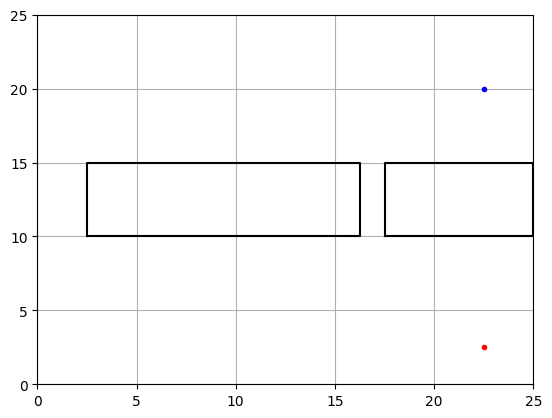

In [5]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot(bx, by, '-k')

ax.plot(x0[0], x0[1], '.r')
ax.plot(xf[0], xf[1], '.b')
ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
plt.grid()

In [6]:
import numpy as np

# Camera Model
class Camera:
    def __init__(self, cam_pos, R, thetaH, thetaV, pan, tilt):
        self.cam_position = cam_pos[0:3]    # [x, y, z], intial position at t0
        self.cam_orientation = cam_pos[3:5] # [pan, tilt], initial position at t0
        self.R = R
        self.pan = pan                      # [min, max, angular rate]
        self.tilt = tilt                    # [min, max, angular rate]
        self.thetaH = thetaH
        self.thetaV = thetaV

    def get_pos(self):
        return self.cam_position
    
    def get_h(self):
        return self.R

    def R1(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    
    def R2(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    
    def R3(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    def get_current_pan(self, timeInstance):
        return self.cam_orientation[0] + self.pan[2]*timeInstance

    def get_current_tilt(self, timeInstance):
        return self.cam_orientation[1] + self.tilt[2]*timeInstance

    def get_direc(self, timeInstance):
        R = self.R
        direc_vec = np.array([[R], [0], [0]])

        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.get_current_pan(timeInstance)
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.get_current_tilt(timeInstance)
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        direc_vec = self.R3(currPan)@self.R2(currTilt)@direc_vec + np.array([[translate[0]], [translate[1]], [translate[2]]])
        return np.hstack([np.array([[translate[0]], [translate[1]], [translate[2]]]), direc_vec])

        
    def get_vertex(self, timeInstance):
        R = self.R
        thH = self.thetaH
        thV = self.thetaV

        # Compute 4 corner of FOV at given time
        vertexFOV = {}
        vertexFOV['0'] = np.array([[R], [-R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        vertexFOV['1'] = np.array([[R], [-R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['2'] = np.array([[R], [R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['3'] = np.array([[R], [R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        
        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.cam_orientation[0] + panRate*timeInstance
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.cam_orientation[1] + tiltRate*timeInstance
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        for i in range(4):
            vertexFOV[str(i)] = self.R3(currPan)@self.R2(currTilt)@vertexFOV[str(i)] + np.array([[translate[0]], [translate[1]], [translate[2]]])
        
        return vertexFOV
        

In [7]:
def rand_conf(rnt):
    # Random
    r = rn.uniform(0, rnt*dQ)
    theta = rn.uniform(0, 2*np.pi)
    psi = rn.uniform(0, 2*np.pi)
    #print(r)
    #print('theta, psi: '+ str(np.rad2deg(theta)) +', '+str(np.rad2deg(psi)))

    x = r*np.sin(psi)*np.cos(theta)
    y = r*np.sin(psi)*np.sin(theta)
    z = r*np.cos(psi)

    return np.array([x, y, z])

In [8]:
def nearest_vertex(qrand, V, T):
    num_node = len(V)
    dist_vec = []
    for i in range(num_node):
        qcheck = V[i]
        dq = qrand-qcheck
        dq_dist = np.sqrt((dq[0])**2+(dq[1])**2+(dq[2])**2)
        if dq_dist > 0 :
            dist_vec.append(dq_dist)
    nearest = dist_vec.index(min(dist_vec))
    return V[nearest], T[nearest]

In [9]:
def inside_map(qrand):
    if qrand[0] >= map_size[0] and qrand[0] <= map_size[1] and qrand[1] >= map_size[2] and qrand[1] <= map_size[3] and qrand[2] >= map_size[4] and qrand[2] <= map_size[5]:
        return True
    else:
        return False 

In [10]:
def outside_building(qrand, building):
    qrandxy = Point(qrand[0:2])

    check_vec = []

    for nb in range(building['nb']):
        building_polygon = Polygon(building[str(nb)]['Polygon'])
        building_height = building[str(nb)]['height']
    
        if not building_polygon.contains(qrandxy) and qrand[2] >= 0 and qrand[2] <= building_height:
            check_vec.append(1)
        else:
            check_vec.append(0)

    if np.sum(check_vec) == building['nb']:
        return True
    else:
        return False

In [11]:
def distance(a, b):
    d = a - b
    return np.sqrt(d[0]**2+d[1]**2+d[2]**2)

In [12]:
def findNeighbors(V, qnew, radius):
    neighbor_vec = []

    dist_vec = []
    node_index_vec = []
    for i in range(len(V)):
        if not distance(V[i], qnew) == 0:
            dist_vec.append(distance(qnew, V[i]))
            node_index_vec.append(i)

    for j in range(len(dist_vec)):
        if dist_vec[j] <= radius:
            neighbor_vec.append(node_index_vec[j])

    # There are close neighbors
    if len(neighbor_vec) > 0:
        return neighbor_vec
    else:
        return None

In [13]:
def outside_FOV(qrand, cam_i, timeToTest):
    cam_pos = cam_i.get_pos()
    cam_pos_h = np.array([cam_pos[0], cam_pos[1], cam_pos[2]])
    cam_pos = np.array([[cam_pos[0]], [cam_pos[1]], [cam_pos[2]]])
    check_inside_vec = []

    # Dictionary containing planes
    # plane0 = base
    # plane1 - 4 = slant planes
    plane = {}
    plane['0'] = np.array([cam_i.get_vertex(timeToTest)['0'], cam_i.get_vertex(timeToTest)['1'], cam_i.get_vertex(timeToTest)['2']])
    plane['1'] = np.array([cam_pos, cam_i.get_vertex(timeToTest)['0'], cam_i.get_vertex(timeToTest)['1']])
    plane['2'] = np.array([cam_pos, cam_i.get_vertex(timeToTest)['1'], cam_i.get_vertex(timeToTest)['2']])
    plane['3'] = np.array([cam_pos, cam_i.get_vertex(timeToTest)['2'], cam_i.get_vertex(timeToTest)['3']])
    plane['4'] = np.array([cam_pos, cam_i.get_vertex(timeToTest)['3'], cam_i.get_vertex(timeToTest)['0']])


    # Iterate over number of planes: 5
    for num_plane in range(5):
        p = plane[str(num_plane)]
        DA = p[1]-p[0]
        DA = np.array([DA[0][0], DA[1][0], DA[2][0]])
        CA = p[2]-p[0]
        CA = np.array([CA[0][0], CA[1][0], CA[2][0]])
        N = np.cross(DA, CA)  # Normal Vector
        if num_plane > 0:
            N = -N
        
        directionVector = np.array([p[0][0][0], p[0][1][0], p[0][2][0]]) - qrand
        value = np.dot(directionVector,N)

        check_inside_vec.append(int(value>0))

    if np.sum(check_inside_vec) == 5 and not checkLOSBlock(qrand, cam_pos_h, building):
        # Inside of camera FOV and no LOS block (so detected)
        return False
    else:
        # Outside of camera FOV or LOS block (so not detected)
        return True

In [14]:
def checkLOSBlock(point, origin, building):
    # Draw line between point and origin
    tick = np.linspace(0, 1, 100)
    for tt in tick:
        currentCheckingPosition = (point-origin)*tt + origin
        checkOutsideBuilding = outside_building(currentCheckingPosition, building)
        
        if checkOutsideBuilding:
            continue # No LOS block
        else:
            return False # LOS block
    return True # No LOS block

In [15]:
def new_conf(qnear, qrand, dQ, tprev, rnt, waittime):
    # get normal direction vector
    dist = qrand - qnear
    norm = np.sqrt(dist[0]**2 + dist[1]**2 + dist[2]**2)
    if not norm == 0:
        direction = dist / norm
    else:
        direction = np.zeros(3,)

    dist_travel = np.linspace(0, dQ*rnt, 100)

    for tt in dist_travel:
        qnew = qnear + direction*tt
        if inside_map(qnew) == False or outside_building(qnew, building) == False:
            return qnew, tprev+tt
    return qnew, tprev + waittime + rnt

In [16]:
def good_path(a, b, camera, num_cam, tprev):
    t = np.linspace(0, 1, 100)
    for tt in t:
        currentCheckingPosition = (b-a)*tt + a
        
        checkInMap = inside_map(currentCheckingPosition)    
        checkOutsideBuilding = outside_building(currentCheckingPosition, building)
        checkOutCamFOVvec = []
        for nc in range(num_cam):
            cam_i = camera[str(nc)]
            checkOutCamFOVvec.append(outside_FOV(currentCheckingPosition, cam_i, tt+tprev))

        if checkInMap and checkOutsideBuilding and np.sum(checkOutCamFOVvec) == num_cam:
            continue
        else:
            return False
    return True

In [17]:
cam_pos = np.array([17.0, 15.0, 10.0, 0.0, np.deg2rad(40)])
R = 10
thetaH = np.deg2rad(54.2)
thetaV = np.deg2rad(41.7)
#thetaH = np.deg2rad(20)
#thetaV = np.deg2rad(20)

pan = np.array([np.deg2rad(0.001), 2*np.pi, np.deg2rad(10)])
tilt = np.array([np.deg2rad(-.001), np.pi/4, 0])
cam0 = Camera(cam_pos, R, thetaH, thetaV, pan, tilt)

camera = {}
num_cam = 1
camera['0'] = cam0


In [18]:
def sample(rnt, qprev, currentTime):
    weight_vec = np.array([0.9, 0.1])
    weight = rn.uniform(0, 0.8)

    if weight <= weight_vec[0]:
        #print('Random')
        qrand = rand_conf(rnt) + qprev
    elif weight > weight_vec[0] and weight <= (weight_vec[0] + weight_vec[1]):
        #print('To Final Point')
        dq = xf - qprev
        norm = np.sqrt(dq[0]**2 + dq[1]**2 + dq[2]**2)
        direc = dq/norm*dQ*rnt
        qrand = qprev + direc
    
    camera_check_vec = []
    for nc in range(num_cam):
        cam_i = camera[str(nc)]
        camera_check_vec.append(outside_FOV(qrand, cam_i, currentTime))

    return camera_check_vec, qrand

In [19]:
def sample_node(rnt, qprev, waittime, V, T):
    weight_vec = np.array([0.9, 0.1])
    weight = rn.uniform(0, 1)

    if weight <= weight_vec[0]:
        #print('Random')
        q = rand_conf(rnt) + qprev
    elif weight > weight_vec[0] and weight <= (weight_vec[0] + weight_vec[1]):
        #print('To Final Point')
        dq = xf - qprev
        norm = np.sqrt(dq[0]**2 + dq[1]**2 + dq[2]**2)
        direc = dq/norm*dQ*rnt
        q = qprev + direc

    qnear, tnear = nearest_vertex(q, V, T)

    camera_check_vec = []
    for nc in range(num_cam):
        cam_i = camera[str(nc)]
        camera_check_vec.append(outside_FOV(q, cam_i, tnear+waittime+rnt))

    if inside_map(q) == True and outside_building(q, building) == True and np.sum(camera_check_vec) == num_cam:
        print("Sample Found")
        # return random node, wait time, movetime, nearest node
        return q, waittime, tnear+waittime+rnt, qnear
    else:
        #print("Waiting")
        return sample_node(rnt, qprev, waittime+rnt, V, T)

In [20]:
def find_mathcing_V(V, parent_node):
    for vi in range(len(V)):
        v = V[vi]
        if v[0] == parent_node[0] and v[1] == parent_node[1] and v[2] == parent_node[2]:
            return vi

In [21]:
# RRT
V = [] # Vertex List
E = [] # Edge List
Parent = [] # Parent List
T = [] # 
Wait_Time = [] # Wait Time List
Move_Time = [] # Move Time List
Cost = [] # Cost List

V.append(x0)
T.append(0)
Parent.append(x0)
Cost.append(0)
Wait_Time.append(0)
Move_Time.append(0)

qprev = x0
tprev = 0
counter = 0

found = False
RRTstar = True

#for k in range(K):
total_time = time.process_time()
while True:
    if counter == 100:
        break

    # Sample Time
    rnt = rn.uniform(0.1, trange)

    start_time1 = time.process_time()
    
    """next = True
    while next:
        print('Sampling')
        # Sample new
        weight_vec = np.array([0.8, 0.1])
        weight = rn.uniform(0, 0.8)

        if weight <= weight_vec[0]:
            #print('Random')
            qrand = rand_conf(rnt) + qprev
        elif weight > weight_vec[0] and weight <= (weight_vec[0] + weight_vec[1]):
            #print('To Final Point')
            dq = xf - qprev
            norm = np.sqrt(dq[0]**2 + dq[1]**2 + dq[2]**2)
            direc = dq/norm*dQ*rnt
            qrand = qprev + direc
        else:
            qrand = qprev

        camera_check_vec = []
        for nc in range(num_cam):
            cam_i = camera[str(nc)]
            camera_check_vec.append(outside_FOV(qrand, cam_i, currentTime))

        if inside_map(qrand) == True and outside_building(qrand, building) == True and np.sum(camera_check_vec) == num_cam:
            next = False
            break"""
    # Sample new:
    qrand = V[-1]
    waittime = 0
    qrand, waittime, currentTime, qnear = sample_node(rnt, qprev, waittime, V, T)

    print('counter: '+str(counter))
    #qnear, tnear = nearest_vertex(qrand, V, T)
    qnew, tnew = new_conf(qnear, qrand, dQ, tprev, rnt, waittime)
    
    end_time1 = time.process_time()
    print('Sampling Time: ', str(end_time1-start_time1))

    print('Checking path...')
    if good_path(qnear, qnew, camera, num_cam, tprev):        
        print('Path is good')
        V.append((qnew))
        E.append((qnear, qnew))
        Parent.append(qnear)
        T.append(tnew)
        Cost.append(distance(qnear, qnew))
        Wait_Time.append(waittime)
        Move_Time.append(rnt)

        # Rewiring
        if RRTstar and counter > 2: # and counter > 3:
            print('Rewiring')
            start_time2 = time.process_time()


            radius = 10#dQ*rnt

            # Find qmin
            qmin = qnear
            #for vindex, v in range(len(V)):
            vcounter = 0
            for v in V:
                if qmin[0] == v[0] and qmin[1] == v[1] and qmin[2] == v[2]:
                    node_index = vcounter
                    break
                vcounter += 1
            cost_qmin = Cost[node_index] + distance(qnear, qnew)

            # Find min-cost path
            qneighbors = findNeighbors(V, qnew, radius)

            if qneighbors is not None:
                for qn in qneighbors:
                    qn_curr = V[qn]
                    # Find time taken from neighbor to new node
                    dist_to_neighbor = distance(qn_curr, qnew)
                    time_to_neighbor = dist_to_neighbor/dQ
                    if good_path(qn_curr, qnew, camera, num_cam, tprev):
                        if Cost[qn] + distance(qn_curr, qnew) < cost_qmin:
                            qmin = V[qn]
                            cost_qmin = Cost[qn] + distance(qn_curr, qnew)
                #E[-1] = (qmin, qnew)
                #Parent[-1] = qmin
                E.append((qmin, qnew))
                Parent.append(qmin)
            end_time2 = time.process_time()
            print('Rewiring Time: ', str(end_time2-start_time2))

        qprev = qnew
        tprev = tnew
        
        counter += 1

total_endtime = time.process_time()
print('Total time taken: ', str(total_endtime - total_time))
    

Sample Found
counter: 0
Sampling Time:  0.010752561999999966
Checking path...
Sample Found
counter: 0
Sampling Time:  0.005877544000000068
Checking path...
Sample Found
counter: 0
Sampling Time:  0.0017924850000001769
Checking path...
Sample Found
counter: 0
Sampling Time:  0.0032748100000001834
Checking path...
Sample Found
counter: 0
Sampling Time:  0.003906642000000016
Checking path...
Sample Found
counter: 0
Sampling Time:  0.0027320139999997828
Checking path...
Sample Found
counter: 0
Sampling Time:  0.0015007790000001187
Checking path...
Sample Found
counter: 0
Sampling Time:  0.0019761699999998328
Checking path...
Sample Found
counter: 0
Sampling Time:  0.004092964999999893
Checking path...
Path is good
Sample Found
counter: 1
Sampling Time:  0.0037174379999997953
Checking path...
Path is good
Sample Found
counter: 2
Sampling Time:  0.005508321000000205
Checking path...
Path is good
Sample Found
counter: 3
Sampling Time:  0.0038972090000002346
Checking path...
Sample Found
count

In [22]:
kek = Parent[-2]
print(Parent)
print(T)

quak = find_mathcing_V(V, kek)
print(quak)
print(V[quak])
print(T[quak])

[array([22.5,  2.5,  3. ]), array([22.5,  2.5,  3. ]), array([20.31415852,  1.66867914,  6.90208507]), array([24.62402048,  5.37872773,  5.13662056]), array([23.03653786,  7.26721981,  4.05195053]), array([22.5,  2.5,  3. ]), array([22.14072964,  3.18456969,  0.35607006]), array([22.5,  2.5,  3. ]), array([22.17762833,  4.91159056,  1.03843177]), array([8.17573173, 9.79245141, 3.94750016]), array([8.17573173, 9.79245141, 3.94750016]), array([8.17573173, 9.79245141, 3.94750016]), array([7.93292296, 9.85736553, 2.88987944]), array([7.33591012, 3.55649056, 4.4891802 ]), array([7.93292296, 9.85736553, 2.88987944]), array([7.33591012, 3.55649056, 4.4891802 ]), array([22.5,  2.5,  3. ]), array([20.31415852,  1.66867914,  6.90208507]), array([22.5,  2.5,  3. ]), array([16.05801153,  5.59552469,  8.42863469]), array([17.413371  , 19.3719045 ,  5.64225819]), array([17.413371  , 19.3719045 ,  5.64225819]), array([18.3992352 , 18.9662834 ,  1.98607946]), array([18.3992352 , 18.9662834 ,  1.986079

(0.0, 25.0)

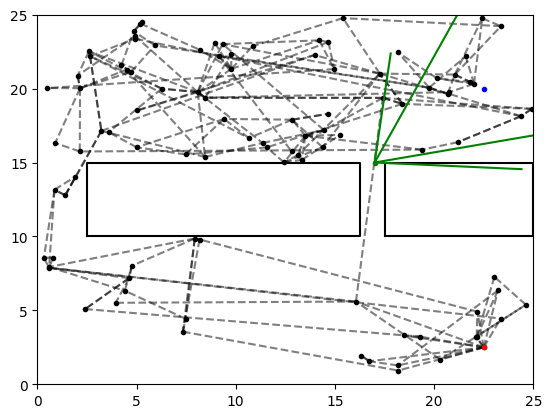

In [23]:
# Path Check
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
    ax.plot(bx, by, '-k')

for kk in range(len(V)):
    ax.plot(V[kk][0], V[kk][1], '.k')

for kk in range(len(E)):
    ax.plot([E[kk][0][0], E[kk][1][0]], [E[kk][0][1], E[kk][1][1]], '--k', alpha=0.5)

camera_vertex = cam0.get_vertex(currentTime)
for i in range(4):
    temp = camera_vertex[str(i)]
    
    if i == 3:
        tempt = camera_vertex[str(0)]
    else:
        tempt = camera_vertex[str(i+1)]
    ax.plot([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], '-g')

ax.plot(cam_pos[0], cam_pos[1], '.g')
ax.plot(x0[0], x0[1], '.r')
ax.plot(xf[0], xf[1], '.b')

ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])

In [26]:
save = True

if save:
    import json
    from json import JSONEncoder

    class NumpyArrayEncoder(JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return JSONEncoder.default(self, obj)
        
    RRT_data = {}
    RRT_data['V'] = V
    RRT_data['E'] = E
    RRT_data['Cost'] = Cost
    RRT_data['Parent'] = Parent
    RRT_data['T'] = T
    RRT_data['Wait'] = Wait_Time

    if RRTstar:
        with open("RRTstar_data4.json", "w") as write_file:
            json.dump(RRT_data, write_file, cls=NumpyArrayEncoder)
    else: 
        with open("RRT_data3.json", "w") as write_file:
            json.dump(RRT_data, write_file, cls=NumpyArrayEncoder)
asdfasfasfd

NameError: name 'asdfasfasfd' is not defined

In [ ]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

(0.0, 10.0)

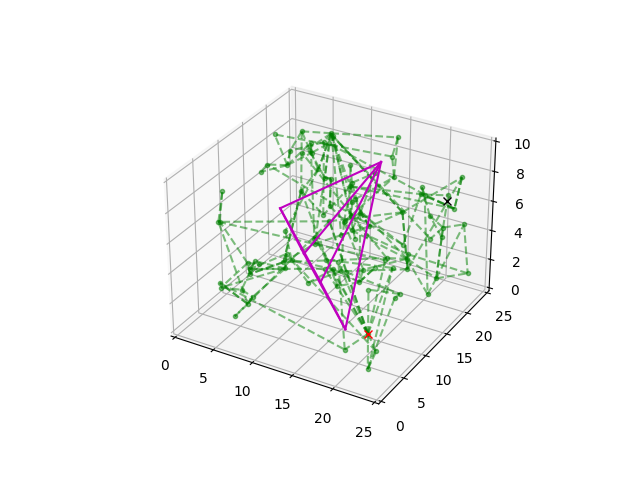

In [28]:
# Visualization

%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot node
k = 0
for v in V:
    ax.plot3D(v[0], v[1], v[2], '.g', alpha=0.5)
    #ax.text(v[0],v[1],v[2],  '%s, %s' % (str(round(Wait_Time[k],2)), str(round(T[k],2))), size=10, zorder=1, color='k')
    k += 1

# Plot edges
for ll in range(len(E)):
    edge1 = E[ll][0]
    edge2 = E[ll][1]
    ax.plot3D([edge1[0], edge2[0]], [edge1[1], edge2[1]], [edge1[2], edge2[2]], '--g', alpha=0.5)

"""for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    for ii in np.linspace(0, building[str(nb)]['height'], 100):
        ax.plot3D(bx, by, np.array([ii, ii, ii, ii, ii]), '-k', alpha=0.5)    
    ax.plot3D(bx, by, bz, '-k')
    ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
    
    for i in range(len(b)):
        ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')"""

camera_vertex = cam0.get_vertex(T[-1])
for i in range(4):
    temp = camera_vertex[str(i)]
    
    if i == 3:
        tempt = camera_vertex[str(0)]
    else:
        tempt = camera_vertex[str(i+1)]
    ax.plot3D([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], [cam_pos[2], temp[2][0]], '-m')
    ax.plot3D([temp[0][0], tempt[0][0]], [temp[1][0], tempt[1][0]], [temp[2][0], tempt[2][0]], '-m')

ax.plot3D(x0[0], x0[1], x0[2], 'xr')
ax.plot3D(xf[0], xf[1], xf[2], 'xk')
ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
ax.set_zlim(map_size[4], map_size[5])